# Setup

In [27]:
import os
import warnings

import numpy as np
from matplotlib import pyplot as plt

from compare_variance_residual.simulated.plotting import plot_experiment
from compare_variance_residual.simulated.simulation import run_experiment

warnings.simplefilter(action='ignore')
plt.style.use('ggplot')

In [28]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [29]:
def get_results(variable_name, variable_values, **variables):
    result_file_names = [
        "variance_r2",
        "variance_direct_r2",
        "residual_r2",
        "variance_rho",
        "variance_direct_rho",
        "residual_rho"
    ]

    experiment_dir = get_experiment_dir(variable_name, **variables)
    paths = [os.path.join(experiment_dir, result_name + ".npy") for result_name in result_file_names]

    # only calculate new results if one file does not exist
    all_paths_exist = all(os.path.exists(path) for path in paths)
    if not all_paths_exist:
        if not os.path.exists(experiment_dir):
            os.makedirs(experiment_dir)
        results = run_experiment(variable_name, variable_values, **variables)
        for result, name in zip(results, result_file_names):
            np.save(str(os.path.join(experiment_dir, name)), result)
    else:
        results = [np.load(path, allow_pickle=True) for path in paths]
        # convert all to lists
        results = [result.tolist() for result in results]
    return results


def get_experiment_dir(variable_name, **variables):
    result_dir = "./results"
    experiment_variables = "".join(
        ['{}={!r}'.format(k,
                          [
                              f"{i:.2f}" if isinstance(i, float) else i  # Handle floats in the list
                              for i in v
                          ] if isinstance(v, list)
                          else f"{v:.2f}" if isinstance(v, float) else v  # Handle floats not in lists
                          )
         for k, v in variables.items()])

    # replace illegal characters
    experiment_variables = experiment_variables.replace(" ", "")
    experiment_variables = experiment_variables.replace("[", "")
    experiment_variables = experiment_variables.replace("]", "")

    # cut filename, if it is too long
    if len(experiment_variables) > 255:
        experiment_variables = experiment_variables[:255]

    experiment_dir = os.path.join(result_dir, variable_name.lower(), experiment_variables)
    return experiment_dir

# Set default values to be used in the tests

In [30]:
n_observations = 3

variables = dict(
    # dataset
    n_runs=50,
    n_observations=n_observations,
    d_list=[100, 100, 100],
    scalars=[1 / 3, 1 / 3, 1 / 3],
    n_targets=100,
    n_samples_train=1000,
    n_samples_test=100,
    noise_level=0.1,
    construction_method="stack",
    random_distribution="normal",

    # method parameters
    use_ols=False,

    # ridge regression
    cv=5,
    alphas=np.logspace(-4, 4, 9),
)

In [31]:
display_names = [
    r"Variance Partitioning $R^2$",
    r"VP direct $R^2$",
    r"Residual $R^2$",
    r"Variance Partitioning $\rho$",
    r"Variance Partitioning $\rho$",
    r"Residual $\rho$"
]


# Varying distributions

In [32]:
variable_name = "Sampling Distribution"
random_distributions = [
    "normal",
    "uniform",
    "exponential",
    "gamma",
    "beta",
    "lognormal",
    "pareto"
]

In [33]:
results = get_results(variable_name, random_distributions, **variables)

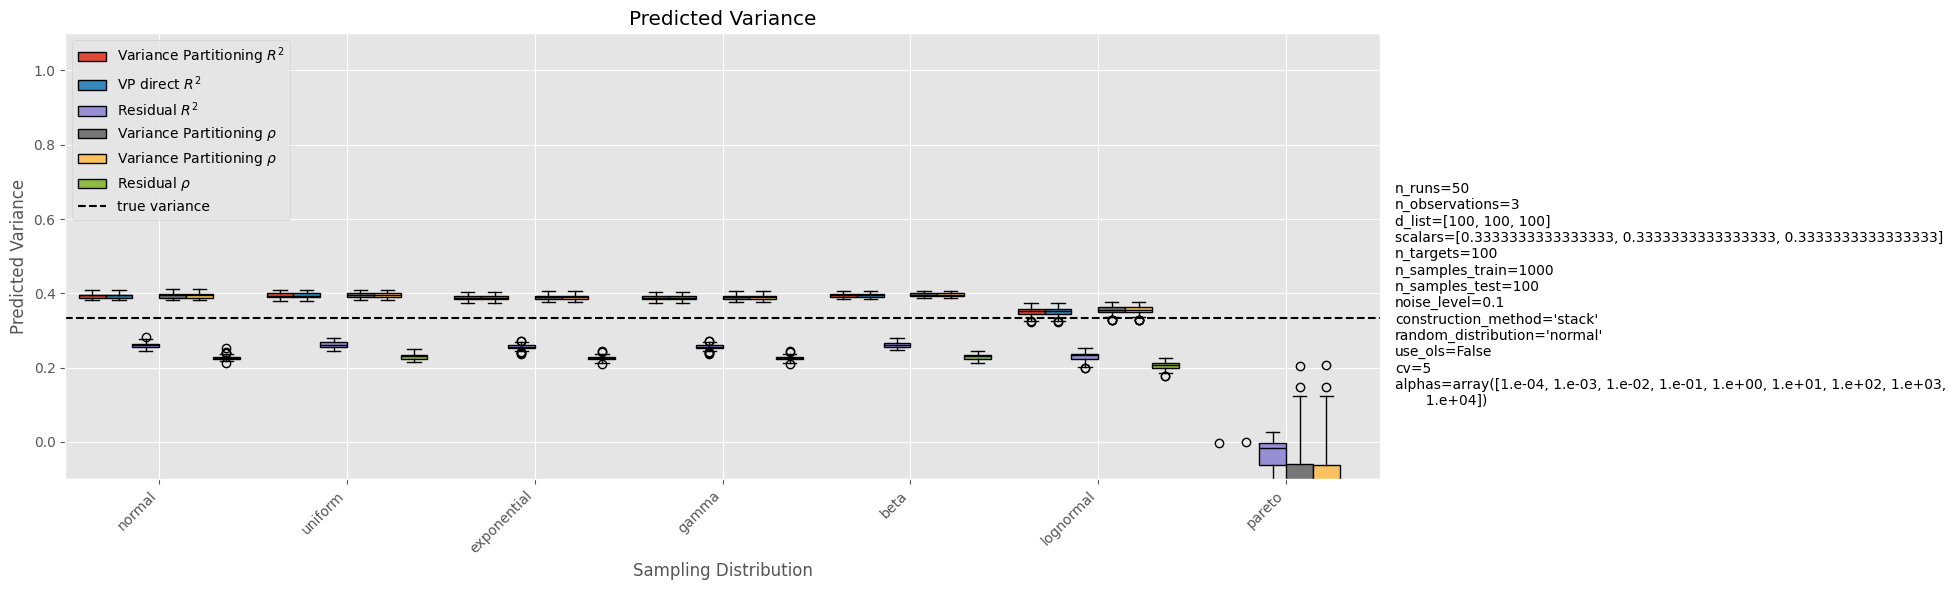

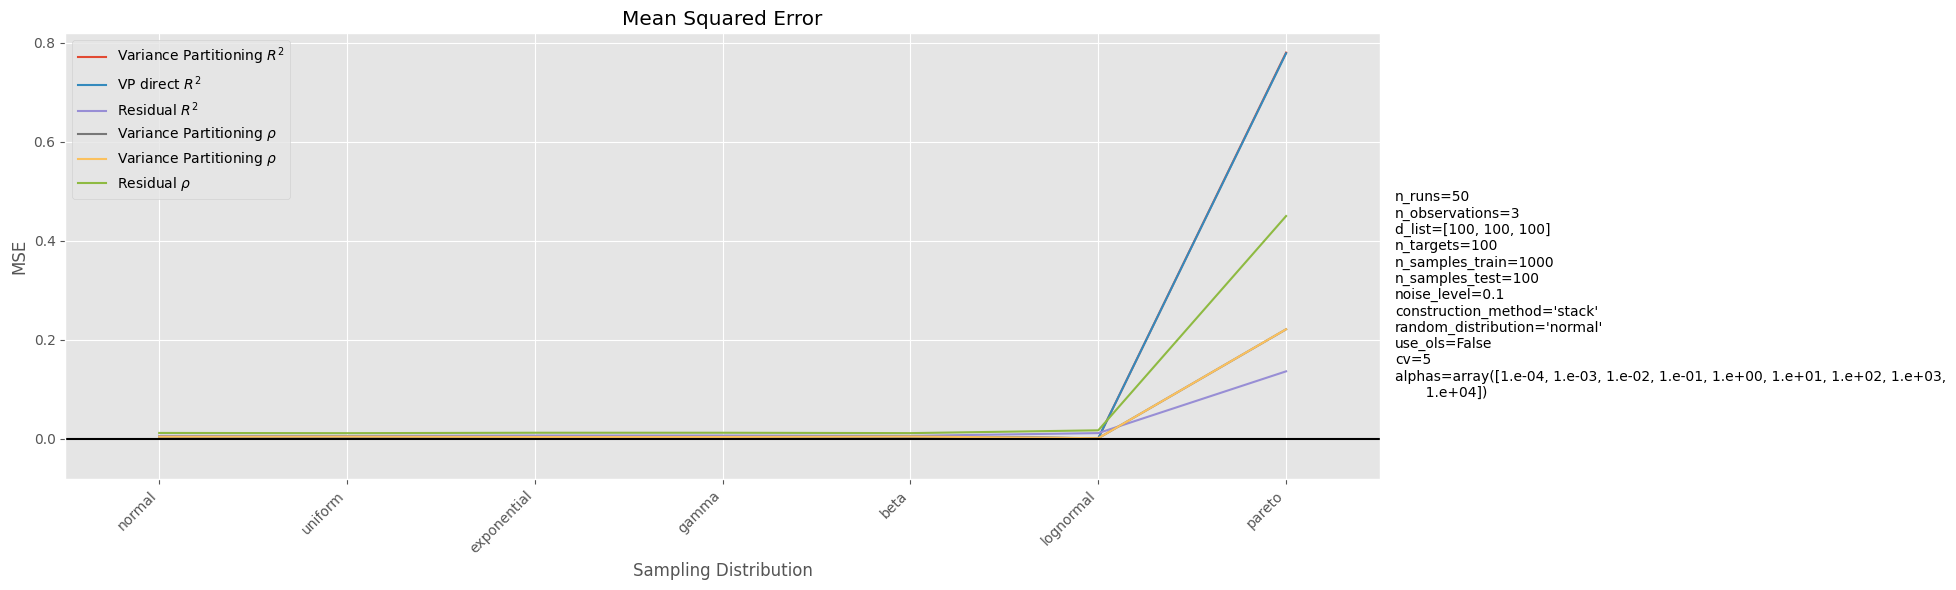

In [34]:
plot_experiment(variable_name, random_distributions, results, display_names,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying sample sizes

## varying train sample sizes

In [35]:
mag = np.log10(variables["n_samples_train"])
sample_sizes_training = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "Number of Samples Training"

In [36]:
results = get_results(variable_name, sample_sizes_training, **variables)

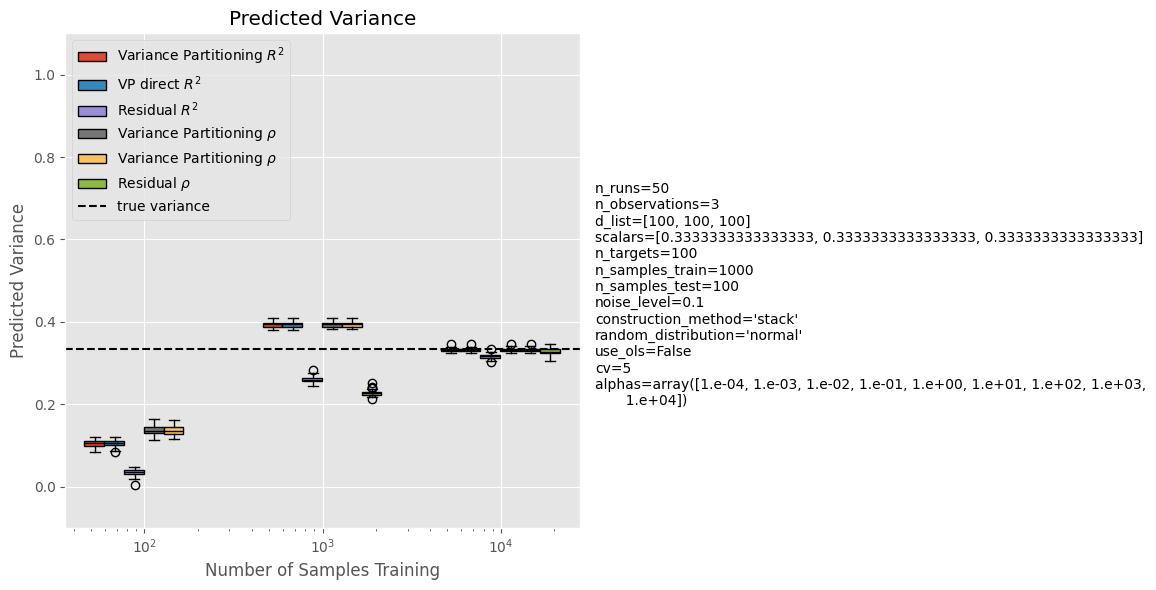

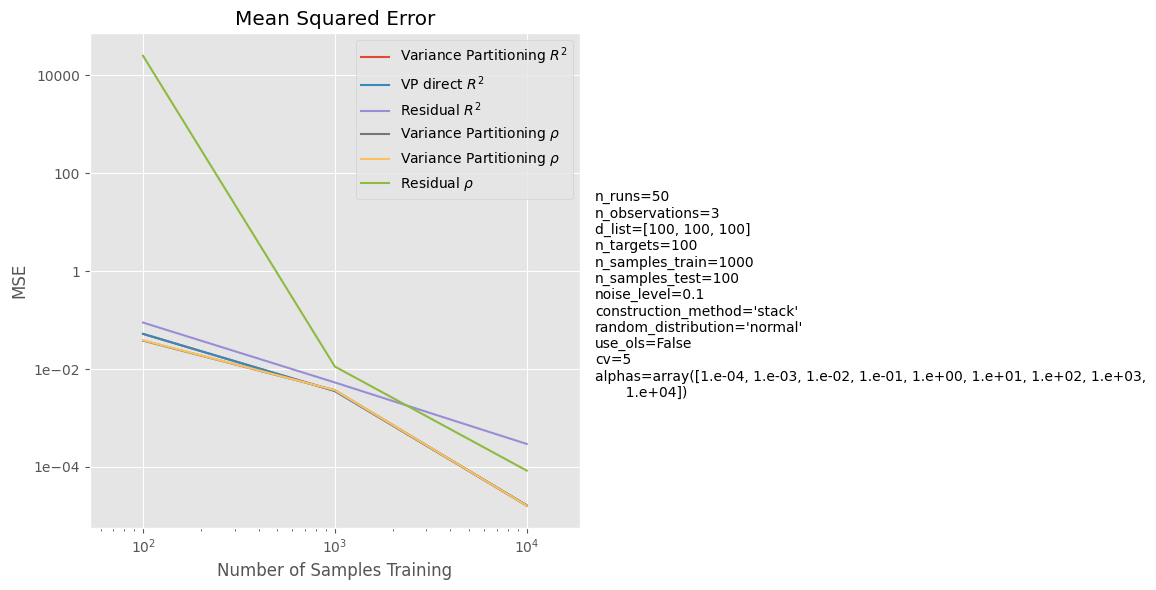

In [37]:
plot_experiment(variable_name, sample_sizes_training, results, display_names, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

## varying test sample sizes

In [38]:
mag = np.log10(variables["n_samples_test"])
sample_sizes_testing = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "Number of Samples Testing"

In [39]:
results = get_results(variable_name, sample_sizes_testing, **variables)

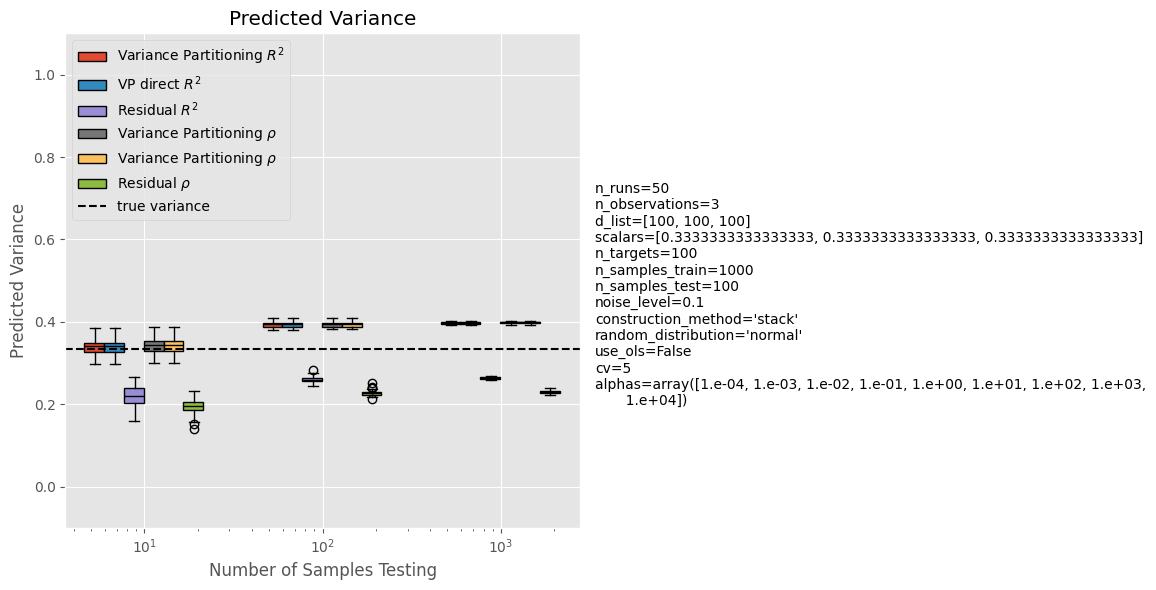

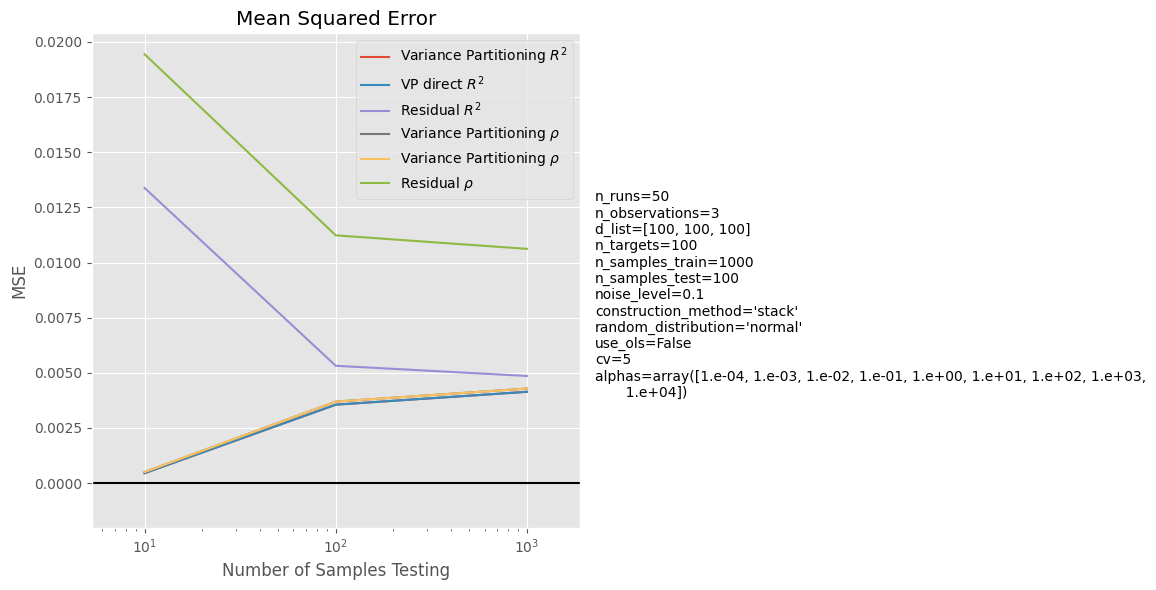

In [40]:
plot_experiment(variable_name, sample_sizes_testing, results, display_names, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying feature sizes

In [41]:
mag = np.log10(variables["d_list"][0])
feature_sizes = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "Number of Features"

In [42]:
results = get_results(variable_name, feature_sizes, **variables)

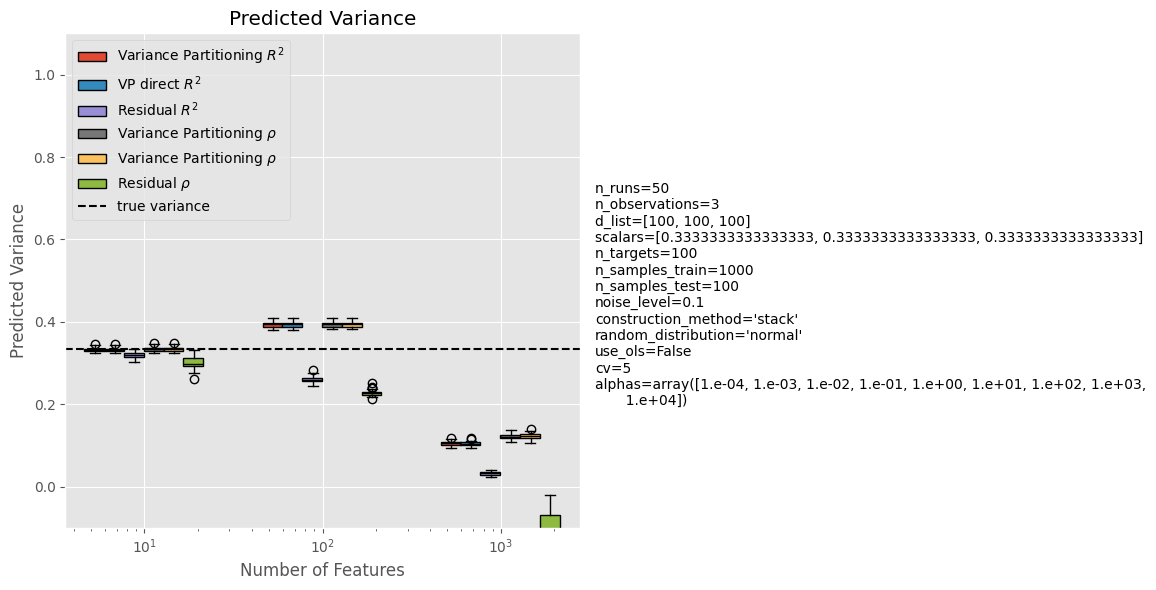

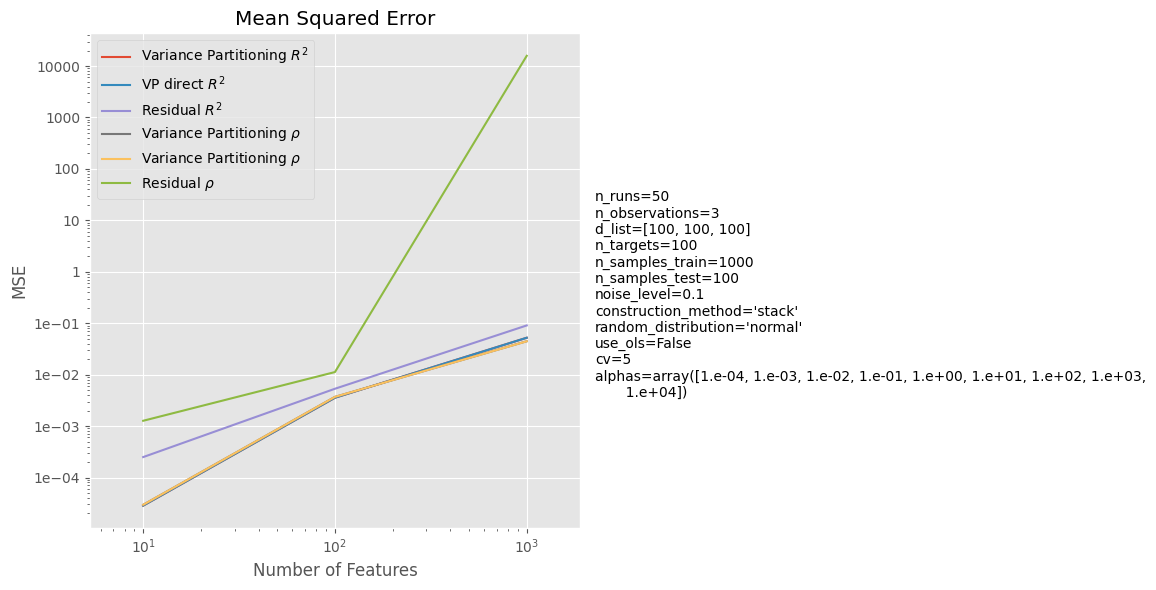

In [43]:
plot_experiment(variable_name, feature_sizes, results, display_names, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# varying target size

In [44]:
variable_name = "Number of Targets"
mag = np.log10(variables["n_targets"])
target_sizes = np.logspace(mag - 1, mag + 1, n_observations)

In [45]:
result = get_results(variable_name, target_sizes, **variables)

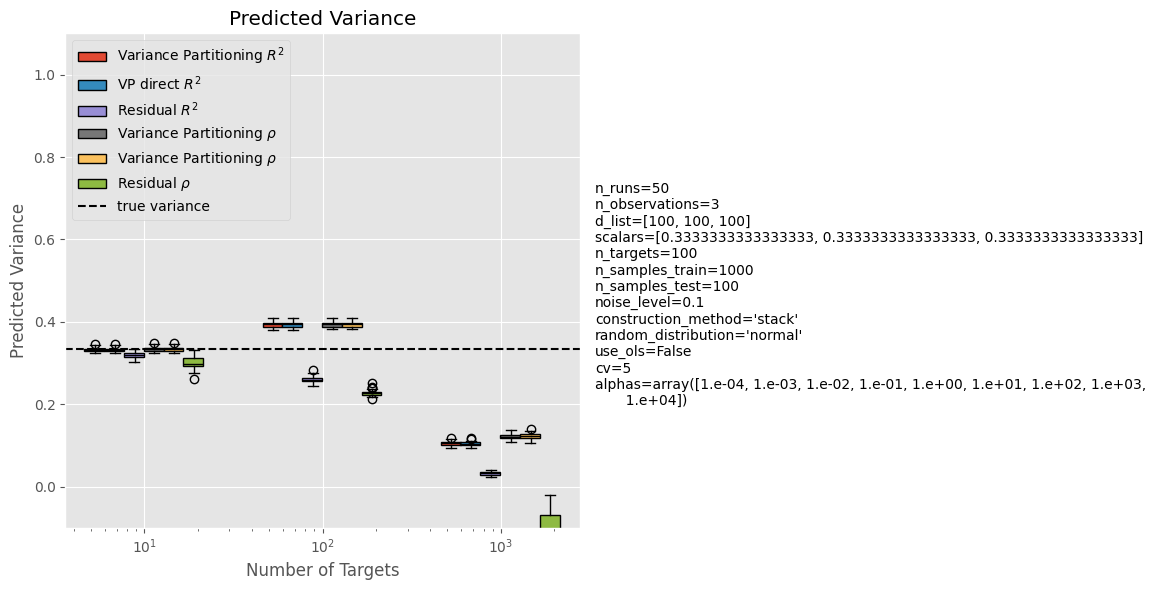

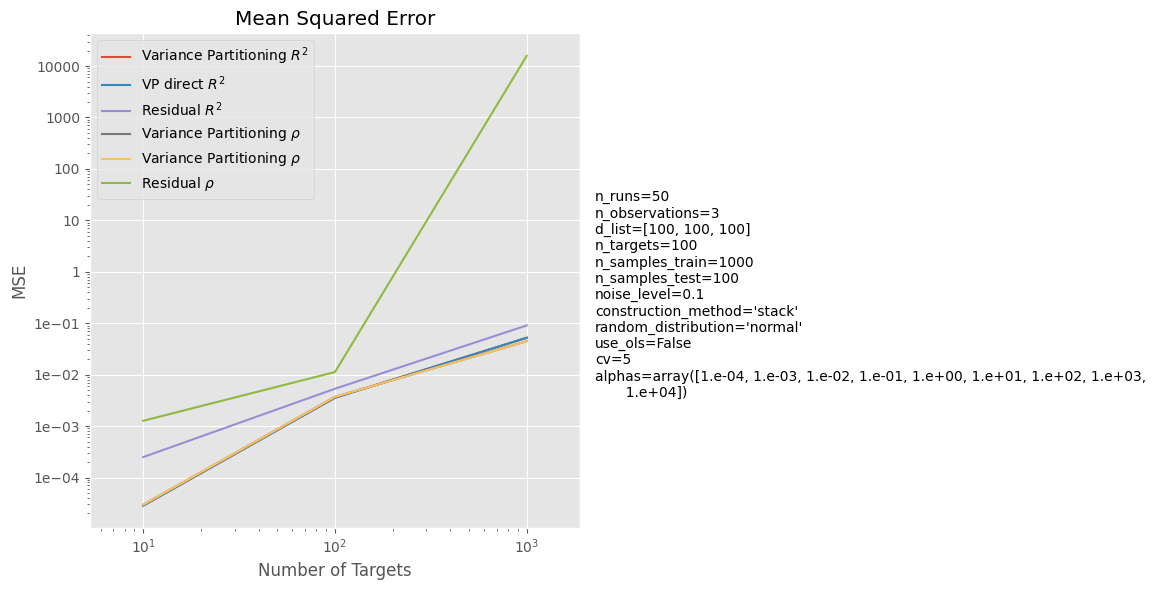

In [46]:
plot_experiment(variable_name, target_sizes, results, display_names, x_is_log=True,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying noise levels

In [47]:
variable_name = "Proportion of Noise Added to Target"
noise_levels = np.linspace(0, 1, n_observations)

In [48]:
results = get_results(variable_name, noise_levels, **variables)

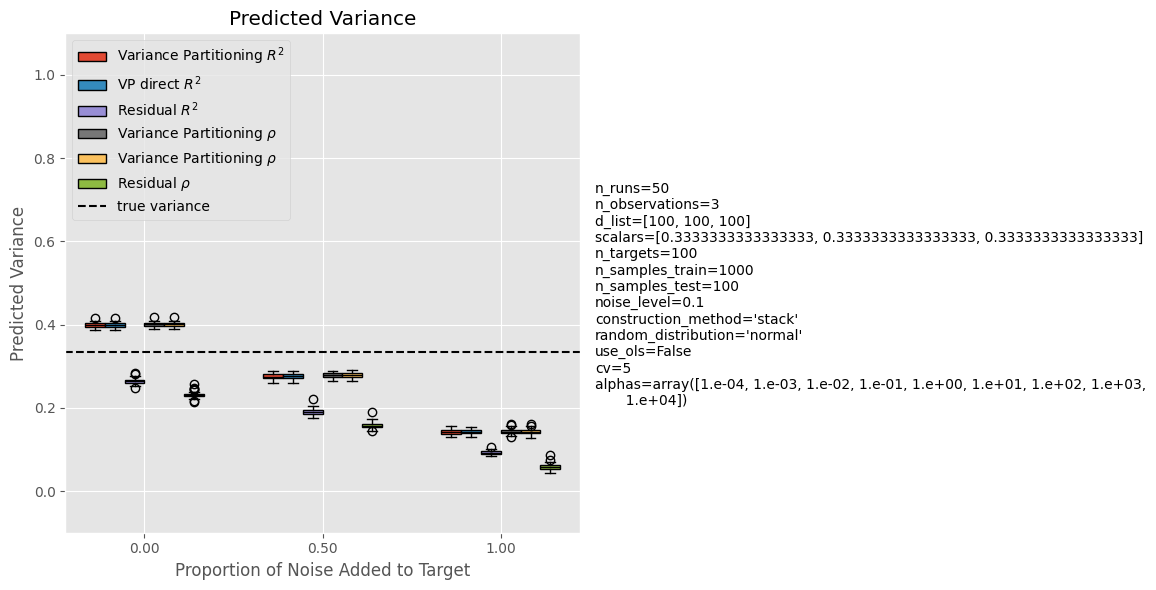

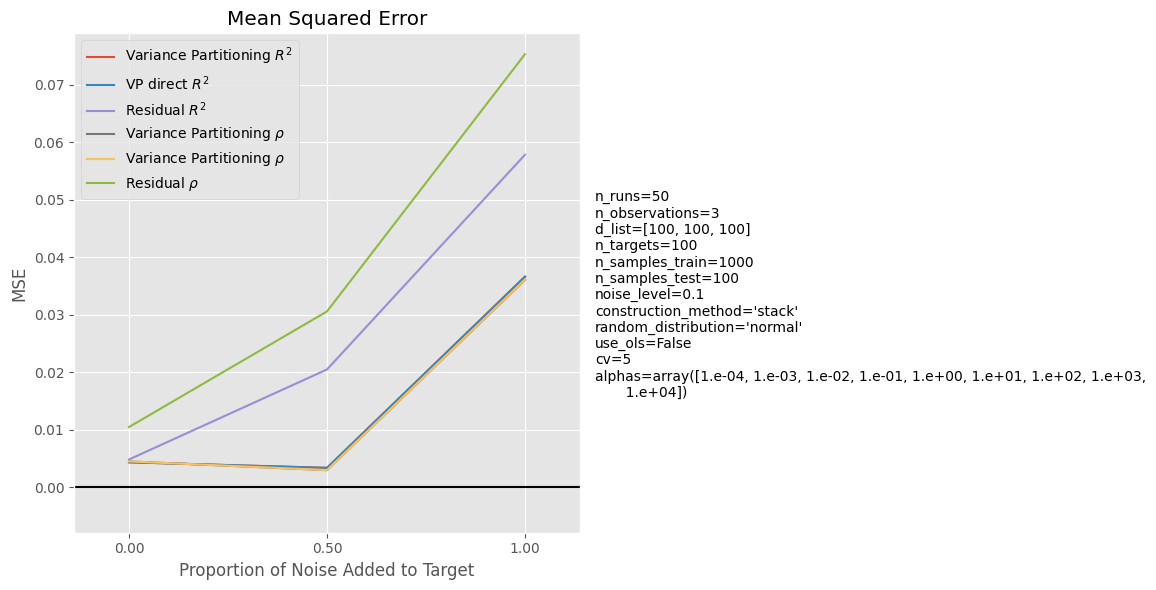

In [49]:
plot_experiment(variable_name, noise_levels, results, display_names,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)

# Test varying unique variances of unique feature spaces

In [50]:
variable_name = "Unique Variance Explained"
unique_variances = np.linspace(0, 1, n_observations)
# convert from np to python
unique_variances = [round(float(x), 2) for x in unique_variances]

In [51]:
variances = []
for unique_variance in unique_variances:
    remainders = (1 - unique_variance) / (len(variables["scalars"]) - 1)
    # construct arrray of arrays, where the second entry is equal to unique_variance and the rest are equal to the remainder
    variance = [remainders] * len(variables["scalars"])
    variance[1] = unique_variance
    variances.append(variance)

result = get_results(variable_name, variances, **variables)

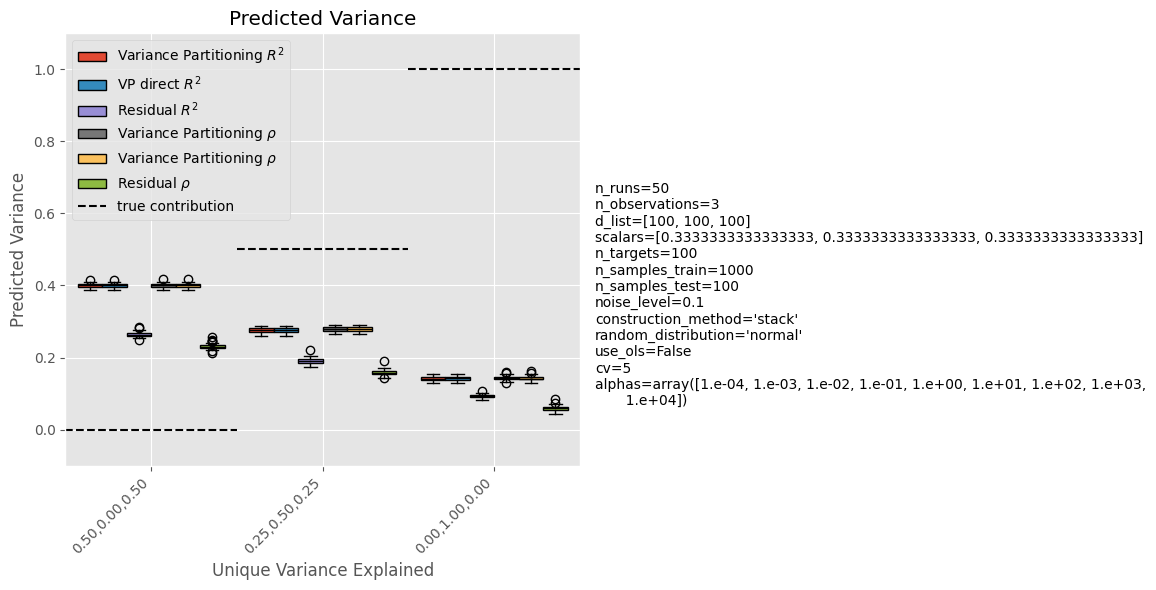

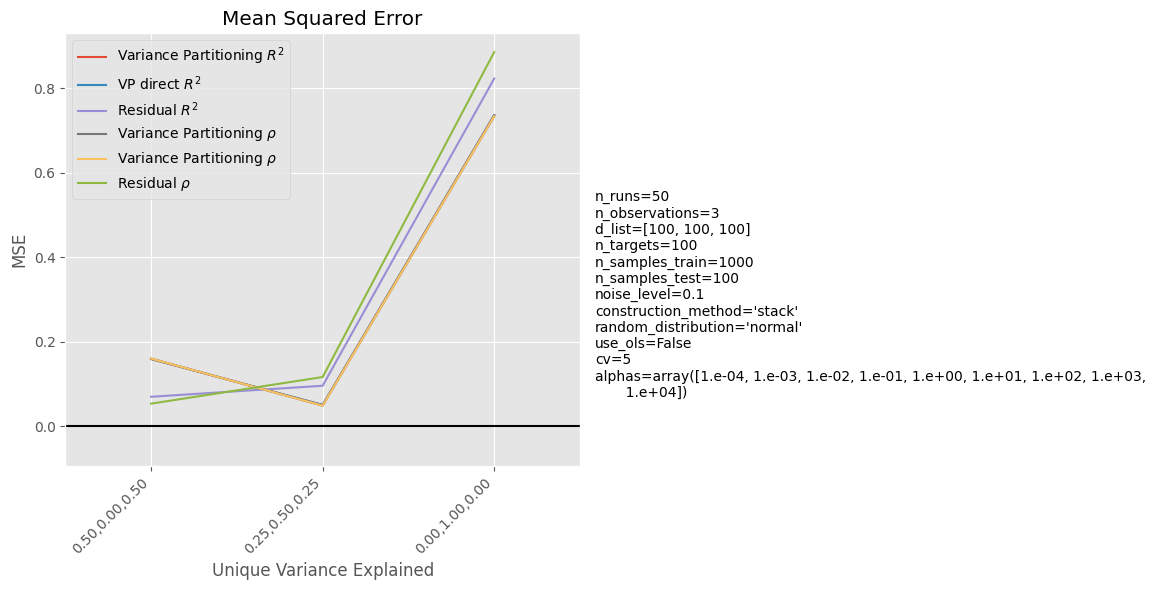

In [52]:
plot_experiment(variable_name, variances, results, display_names,
                save_dir=get_experiment_dir(variable_name, **variables), **variables)